In [34]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression

In [35]:
target = "Inflation Rate (%)"
chart_target = "inflation"
file_tag = "Differentiation"

train_path = "../../data/prepared/aggregation/inflation_train_aggregation.csv"
test_path  = "../../data/prepared/aggregation/inflation_test_aggregation.csv"

train_df = read_csv(train_path, parse_dates=["Date"], index_col="Date")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Date"], index_col="Date")
test: Series = test_df[target]
test.index = to_datetime(test.index)

train.head(), test.head()

(Date
 2010-01-01    5.837500
 2011-01-01    2.756667
 2012-01-01    6.438000
 2013-01-01    9.630000
 2014-01-01    3.800000
 Name: Inflation Rate (%), dtype: float64,
 Date
 2020-01-01    6.350
 2021-01-01    0.530
 2022-01-01    5.480
 2023-01-01    5.145
 Name: Inflation Rate (%), dtype: float64)

**Differentiation**

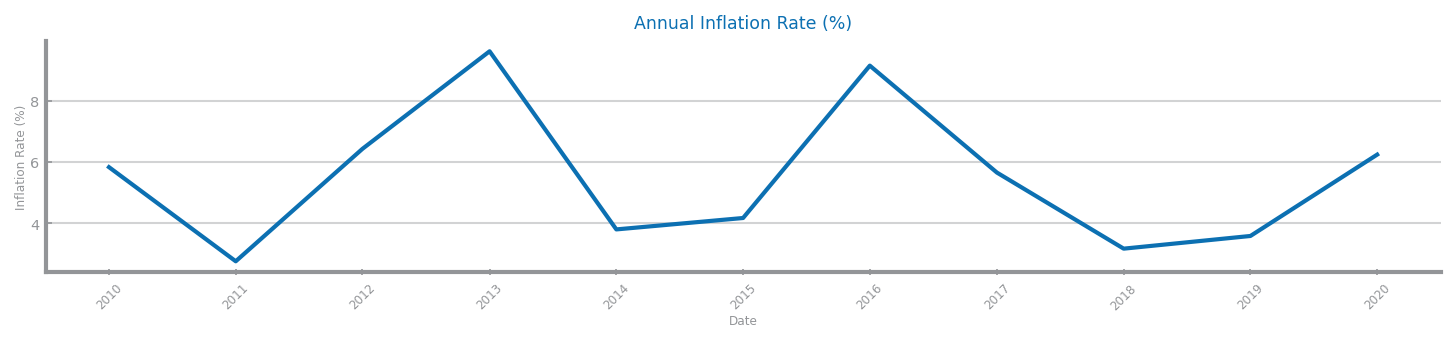

In [36]:
# without any differentiation
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"Annual {target}",
)
show()

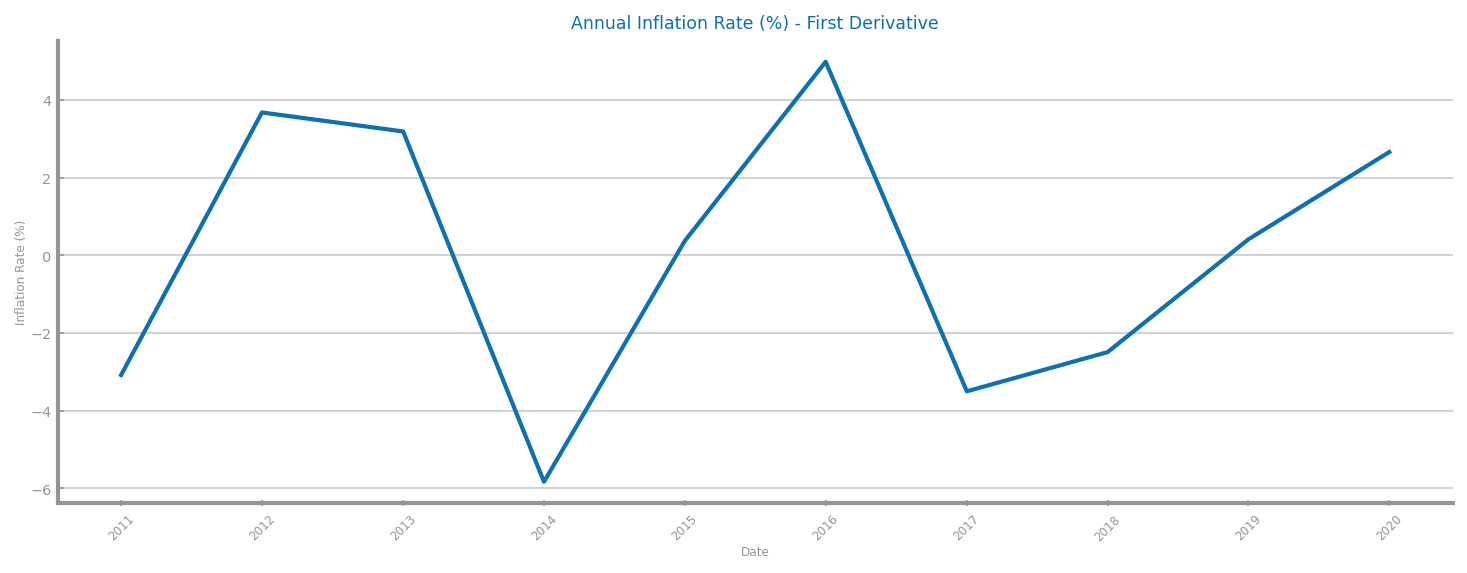

In [37]:
# differential of 1
train_diff1 = train.diff()
test_diff1 = test.diff()
test_diff1.iloc[0] = test.iloc[0] - train.iloc[-1] # bc needs continuity to the end of training set

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    train_diff1.index.to_list(),
    train_diff1.to_list(),
    title=f"Annual {target} - First Derivative",
    xlabel=train_diff1.index.name,
    ylabel=target,
)
show()

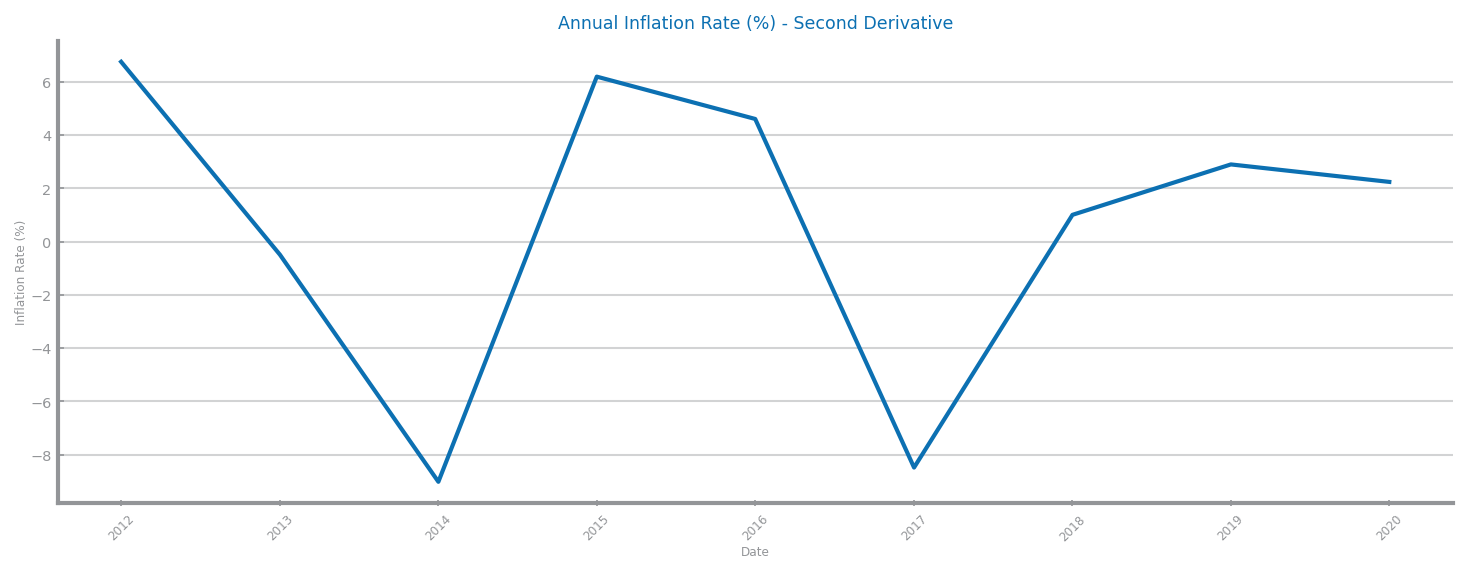

In [38]:
# differential of 2
train_diff2 = train.diff().diff()
test_diff2 = test.diff().diff()

first_diff_train_last = train.diff().iloc[-1]
first_diff_test0 = test.iloc[0] - train.iloc[-1]
test_diff2.iloc[0] = first_diff_test0 - first_diff_train_last

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    train_diff2.index.to_list(),
    train_diff2.to_list(),
    title=f"Annual {target} - Second Derivative",
    xlabel=train_diff2.index.name,
    ylabel=target,
)
show()

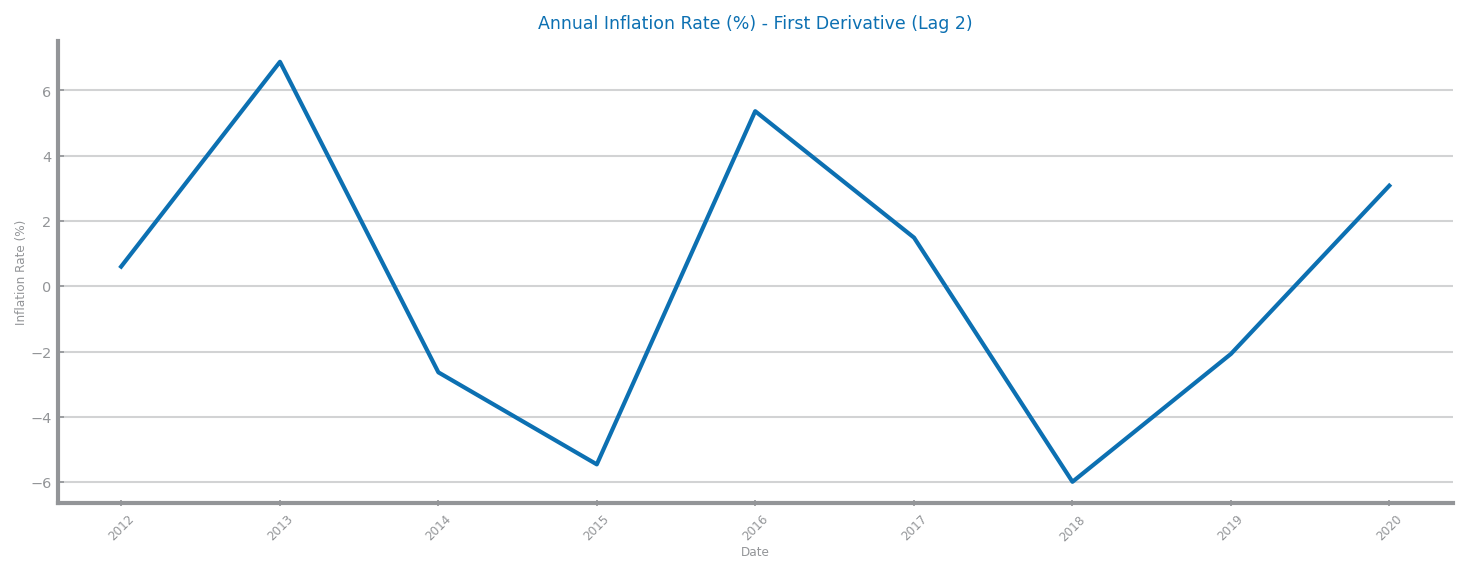

In [39]:
# differential of 1 with lag of 2
train_diff_lag2 = train.diff(2)
test_diff_lag2 = test.diff(2)

test_diff_lag2.iloc[0] = test.iloc[0] - train.iloc[-2]
test_diff_lag2.iloc[1] = test.iloc[1] - train.iloc[-1]

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    train_diff_lag2.index.to_list(),
    train_diff_lag2.to_list(),
    title=f"Annual {target} - First Derivative (Lag 2)",
    xlabel=train_diff_lag2.index.name,
    ylabel=target,
)
show()

**Evaluation**

**Persistent Realist**

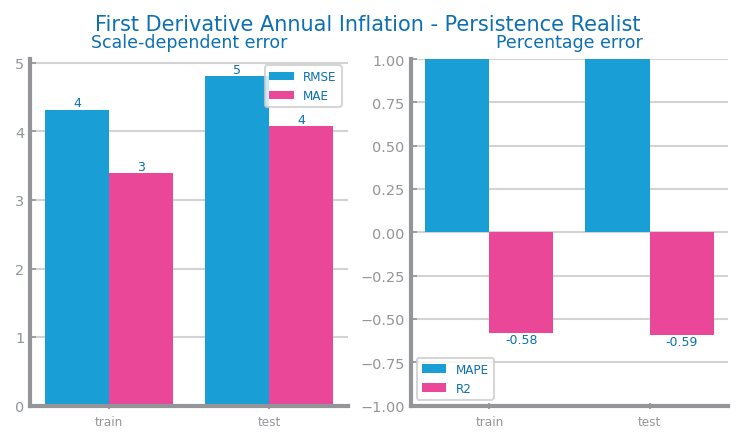

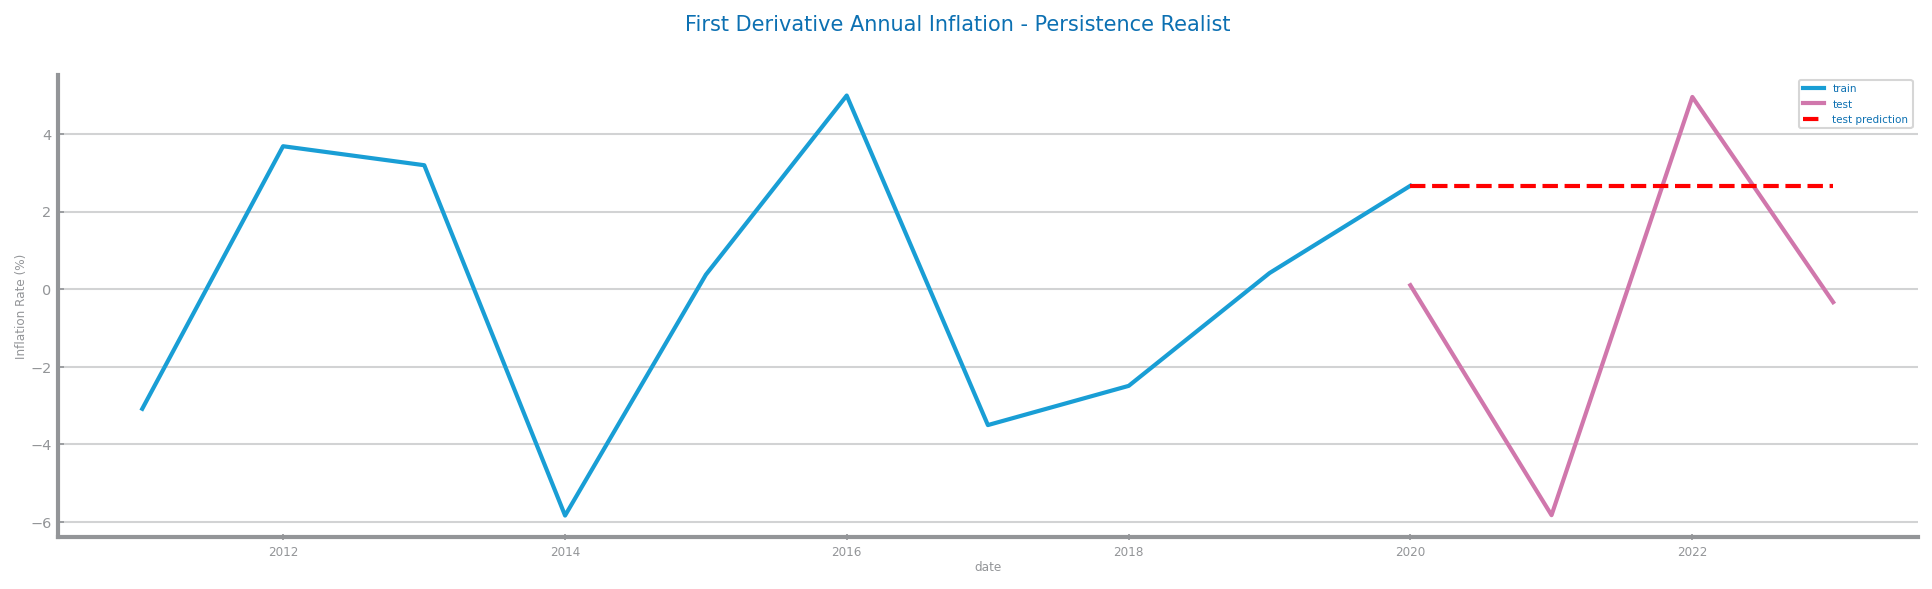

In [40]:
train_diff1 = train_diff1.dropna()
timecol="date"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff1)
prd_trn_diff1: Series = fr_mod.predict(train_diff1)
prd_tst_diff1: Series = fr_mod.predict(test_diff1)

plot_forecasting_eval(train_diff1, test_diff1, prd_trn_diff1, prd_tst_diff1, title=f"First Derivative Annual Inflation - Persistence Realist")
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_persistence_real_diff1_eval.png")

plot_forecasting_series(
    train_diff1,
    test_diff1,
    prd_tst_diff1,
    title=f"First Derivative Annual Inflation - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_persistence_real_diff1_forecast.png")


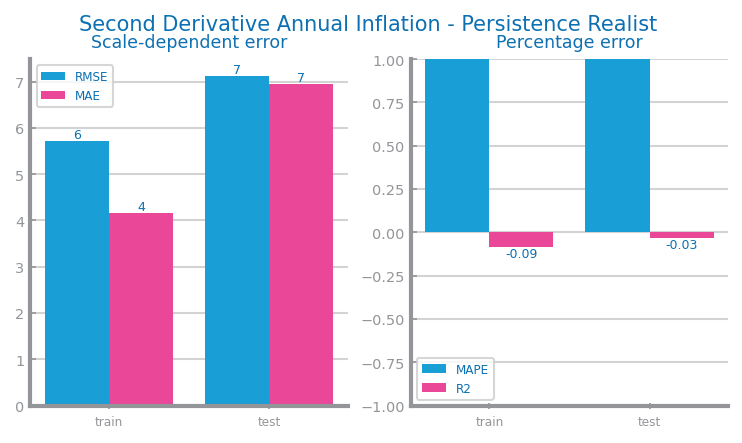

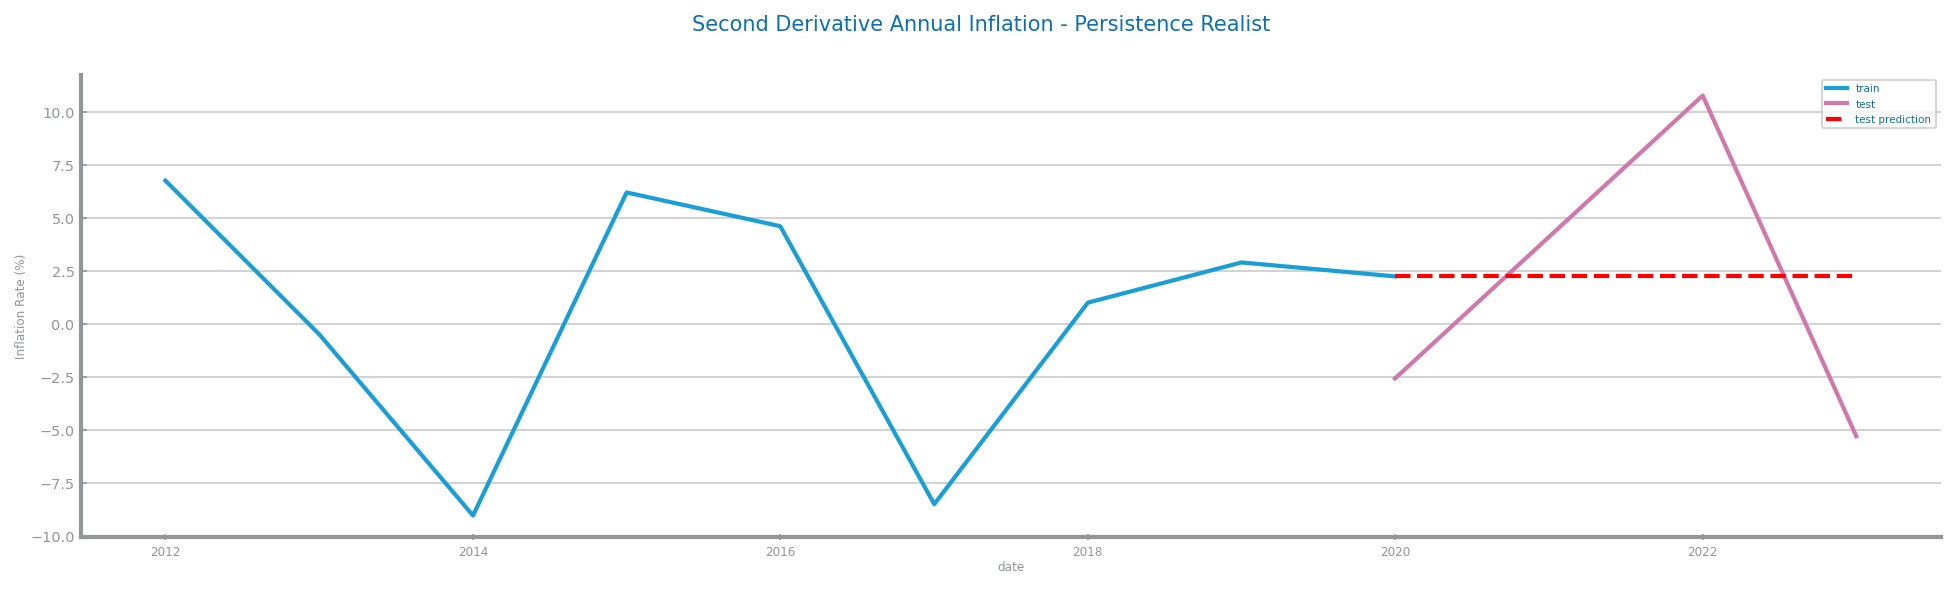

In [41]:
train_diff2 = train_diff2.dropna()
test_diff2 = test_diff2.dropna()
timecol="date"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff2)
prd_trn_diff2: Series = fr_mod.predict(train_diff2)
prd_tst_diff2: Series = fr_mod.predict(test_diff2)

plot_forecasting_eval(train_diff2, test_diff2, prd_trn_diff2, prd_tst_diff2, title=f"Second Derivative Annual Inflation - Persistence Realist")
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_persistence_real_diff2_eval.png")

plot_forecasting_series(
    train_diff2,
    test_diff2,
    prd_tst_diff2,
    title=f"Second Derivative Annual Inflation - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_persistence_real_diff2_forecast.png")


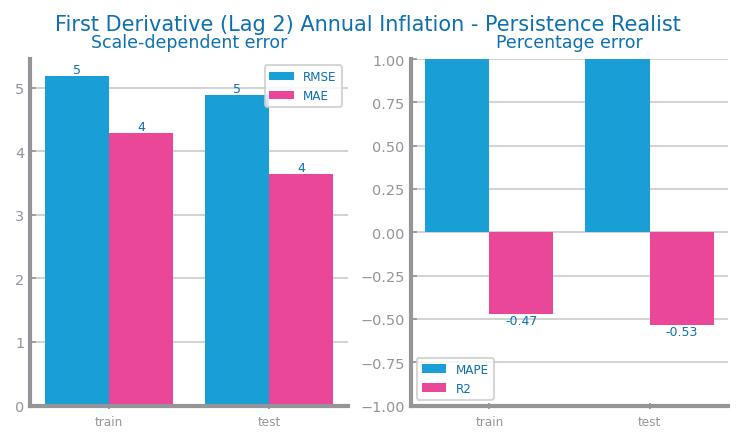

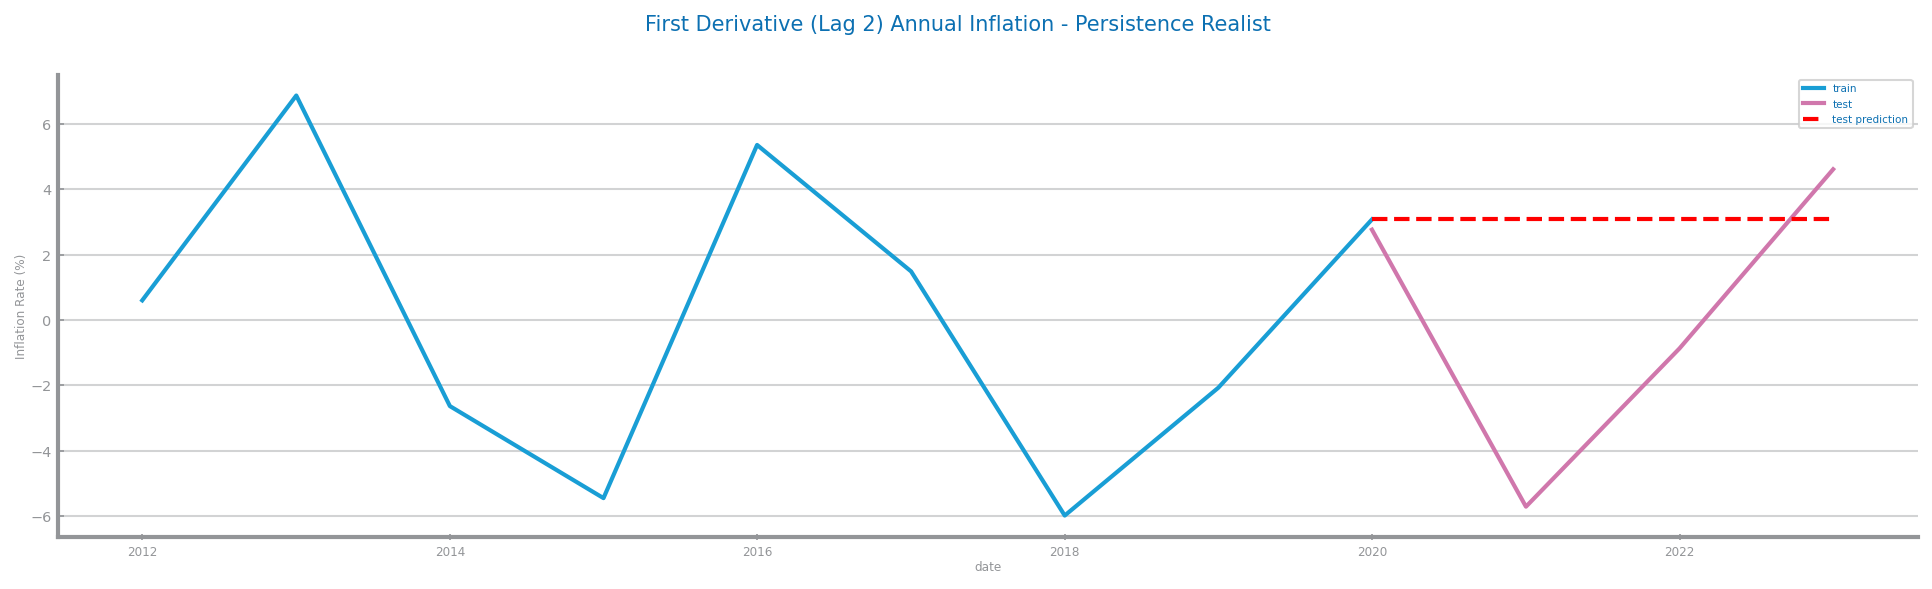

In [42]:
train_diff_lag2 = train_diff_lag2.dropna()
timecol="date"

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_diff_lag2)
prd_trn_diff_lag2: Series = fr_mod.predict(train_diff_lag2)
prd_tst_diff_lag2: Series = fr_mod.predict(test_diff_lag2)

plot_forecasting_eval(train_diff_lag2, test_diff_lag2, prd_trn_diff_lag2, prd_tst_diff_lag2, title=f"First Derivative (Lag 2) Annual Inflation - Persistence Realist")
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_persistence_real_diff_lag2_eval.png")

plot_forecasting_series(
    train_diff_lag2,
    test_diff_lag2,
    prd_tst_diff_lag2,
    title=f"First Derivative (Lag 2) Annual Inflation - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_persistence_real_diff_lag2_forecast.png")


**Linear Regression**

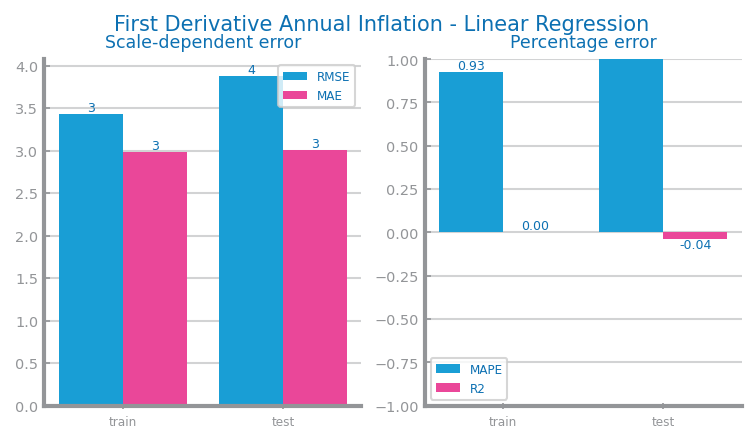

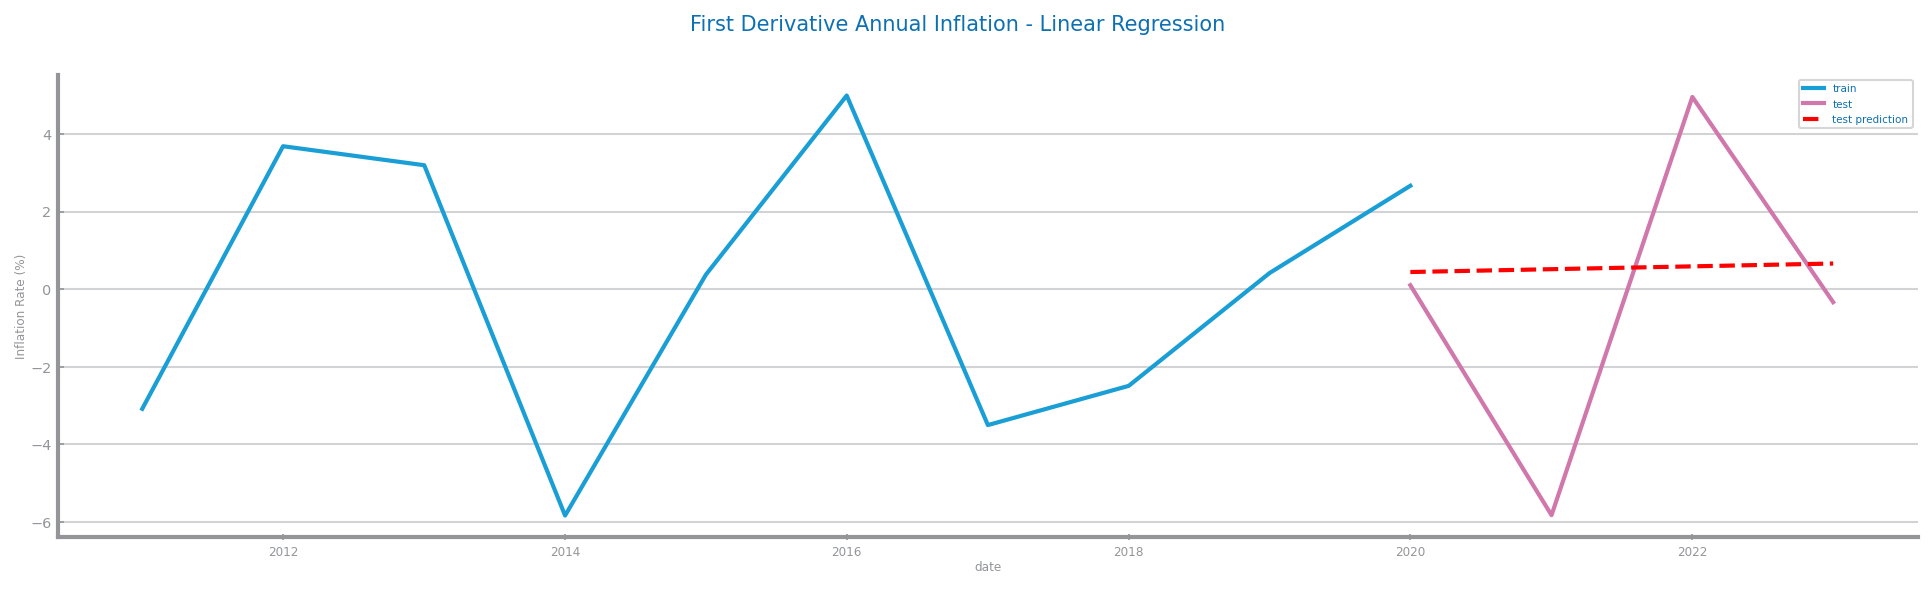

In [43]:
n_trn = len(train_diff1)
n_tst = len(test_diff1)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_diff1.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_diff1.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_diff1: Series = Series(model.predict(trnX), index=train_diff1.index)
prd_tst_diff1: Series = Series(model.predict(tstX), index=test_diff1.index)

plot_forecasting_eval(
    train_diff1,
    test_diff1,
    prd_trn_diff1,
    prd_tst_diff1,
    title=f"First Derivative Annual Inflation - Linear Regression"
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_linear_regression_diff1_eval.png")

plot_forecasting_series(
    train_diff1,
    test_diff1,
    prd_tst_diff1,
    title=f"First Derivative Annual Inflation - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_linear_regression_diff1_forecast.png")

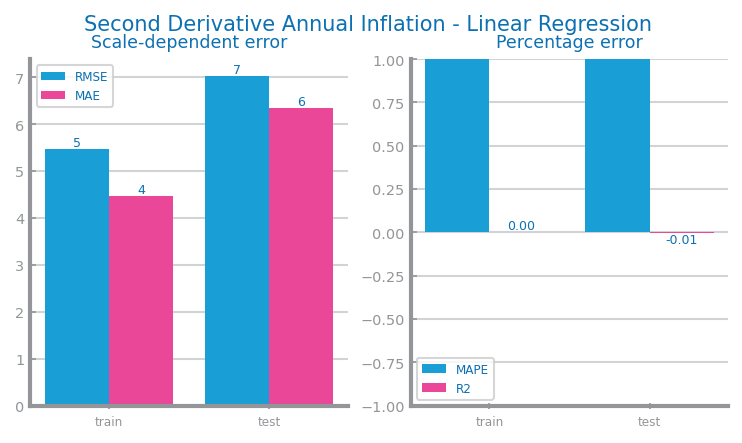

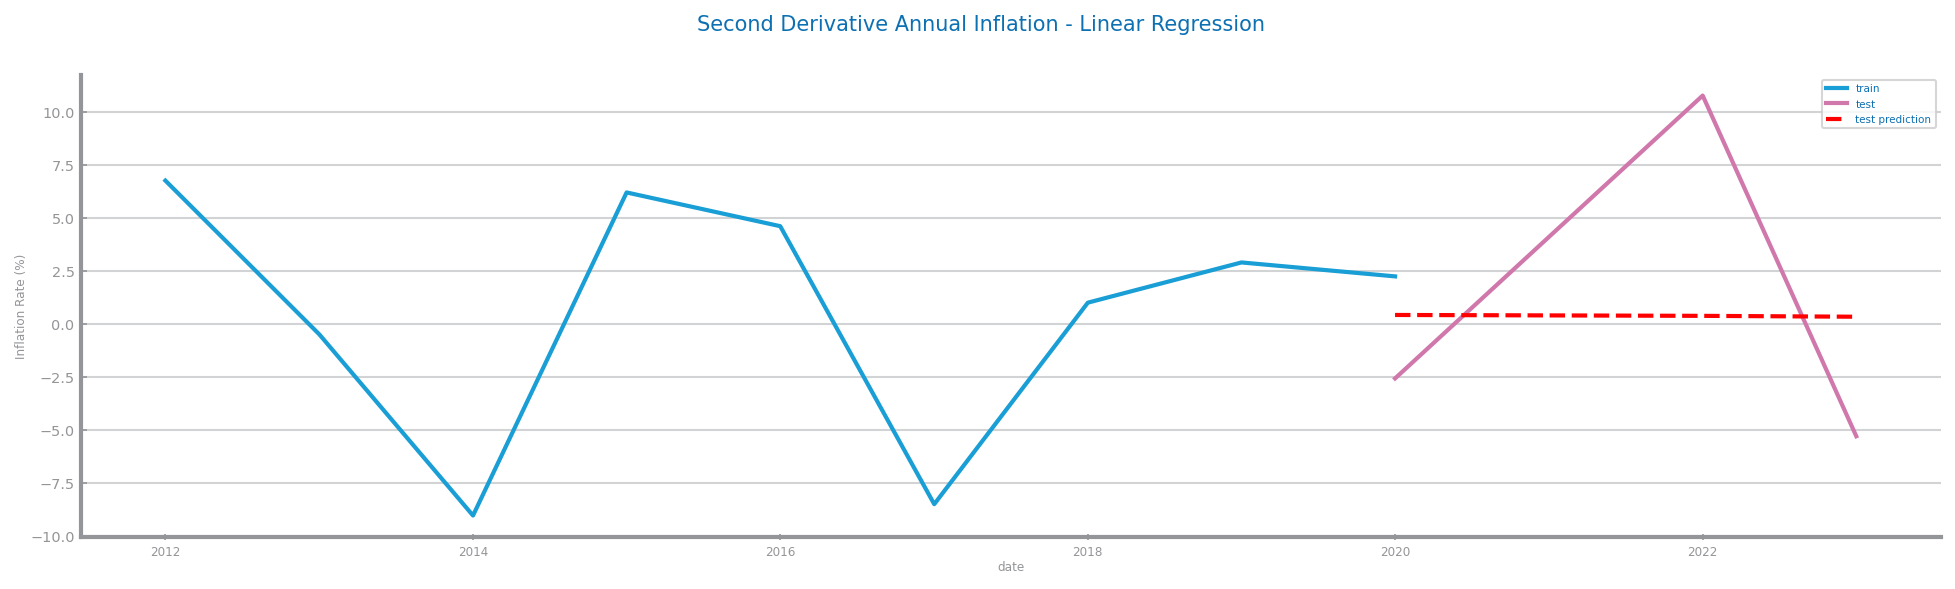

In [44]:
n_trn = len(train_diff2)
n_tst = len(test_diff2)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_diff2.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_diff2.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_diff2: Series = Series(model.predict(trnX), index=train_diff2.index)
prd_tst_diff2: Series = Series(model.predict(tstX), index=test_diff2.index)

plot_forecasting_eval(
    train_diff2,
    test_diff2,
    prd_trn_diff2,
    prd_tst_diff2,
    title=f"Second Derivative Annual Inflation - Linear Regression"
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_linear_regression_diff2_eval.png")

plot_forecasting_series(
    train_diff2,
    test_diff2,
    prd_tst_diff2,
    title=f"Second Derivative Annual Inflation - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_linear_regression_diff2_forecast.png")

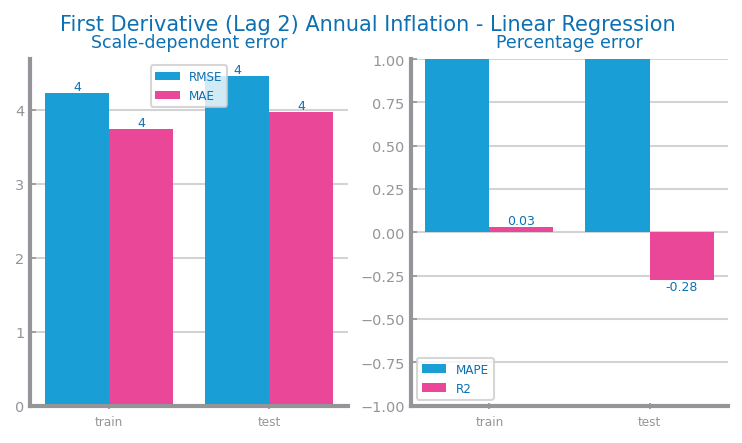

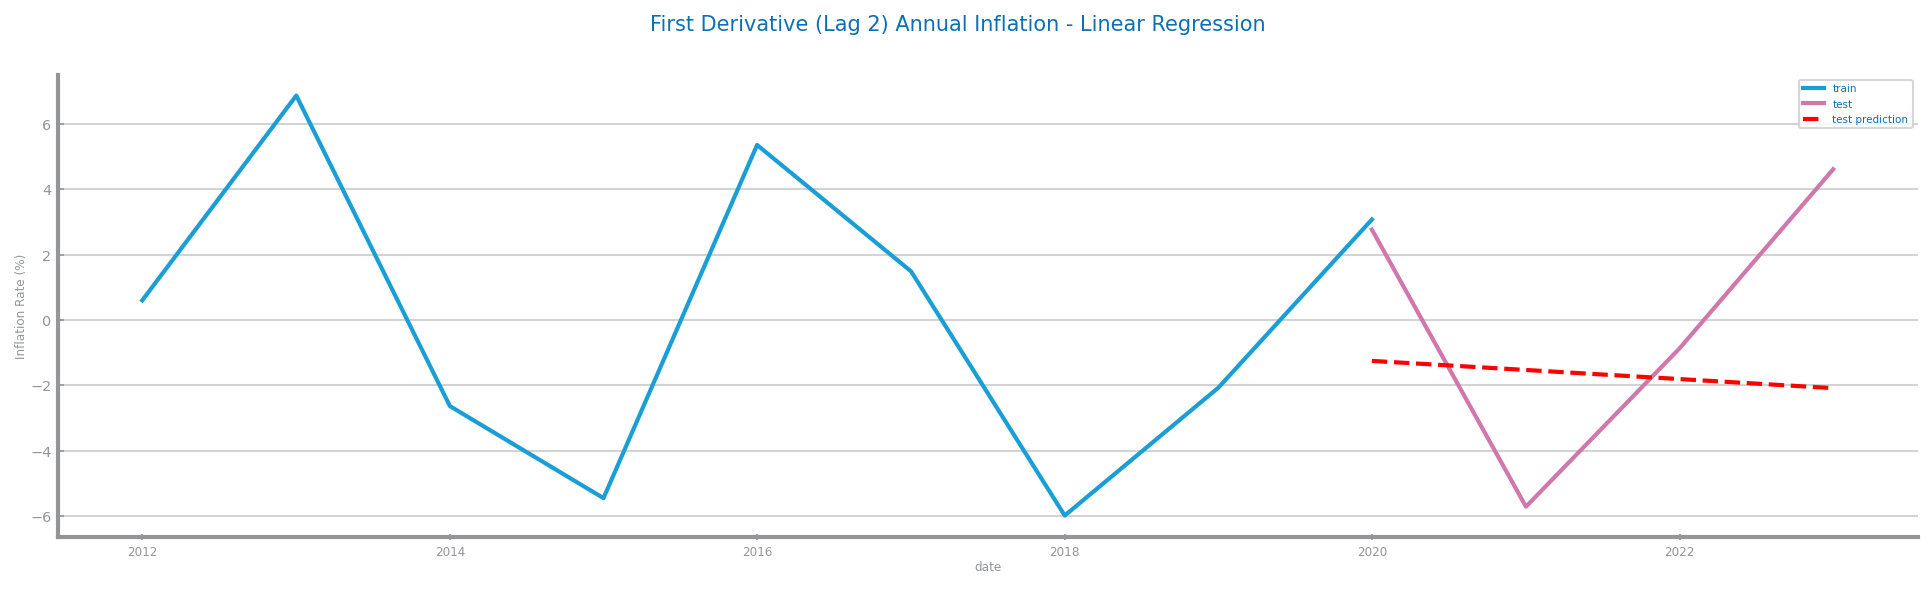

In [45]:
n_trn = len(train_diff_lag2)
n_tst = len(test_diff_lag2)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_diff_lag2.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_diff_lag2.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_diff_lag2: Series = Series(model.predict(trnX), index=train_diff_lag2.index)
prd_tst_diff_lag2: Series = Series(model.predict(tstX), index=test_diff_lag2.index)

plot_forecasting_eval(
    train_diff_lag2,
    test_diff_lag2,
    prd_trn_diff_lag2,
    prd_tst_diff_lag2,
    title=f"First Derivative (Lag 2) Annual Inflation - Linear Regression"
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_linear_regression_diff_lag2_eval.png")

plot_forecasting_series(
    train_diff_lag2,
    test_diff_lag2,
    prd_tst_diff_lag2,
    title=f"First Derivative (Lag 2) Annual Inflation - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/differential/{file_tag}_linear_regression_diff_lag2_forecast.png")

**Evaluation Notes:**

for diff_1 and diff_2, the Linear Regression Model yields a lower RMSE for the test set than the Persistent Realist models.

For the diff_lag2 treatment, the Persistent Realist has a lower RMSE than the Linear Regression Model.

But overall, the best model, a Linear Regression Model trained on the diff_1 treatment, is worse than the best model without differential treatment. So, we do not differentiate.

In [46]:
output_train_path = "../../data/prepared/differential/inflation_train_aggregation.csv"
output_test_path  = "../../data/prepared/differential/inflation_test_aggregation.csv"

# Ensure they are DataFrames so the index is preserved cleanly
train.to_frame(name="Inflation Rate (%)").to_csv(output_train_path)
test.to_frame(name="Inflation Rate (%)").to_csv(output_test_path)

print("Saved train/test sets - no differential treatment.")

Saved train/test sets - no differential treatment.
